# Imports

In [ ]:
import os
from datetime import datetime
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import RandomTranslation
import matplotlib.pyplot as plt
import random
%matplotlib inline


seed = 42
random.seed(seed)  # Imposta il seed per il modulo random
np.random.seed(seed)  # Imposta il seed per numpy
tf.random.set_seed(seed)

BATCH_SIZE = 64

# Load Data

In [ ]:
training_data = np.load("/kaggle/input/cleaned/mars_for_students_cleaned_compressed.npz")
images = training_data["images"]/255.0
labels = training_data["labels"]

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2)

# Augmentations

In [ ]:
"add_channel"
def add_channel(image, label):
    image = tf.cast(image, tf.float32)
    label = tf.cast(label, tf.float32)
    image = tf.expand_dims(image, axis=-1)
    label = tf.expand_dims(label, axis=-1)
    return image, label

def add_channel_lambda(dataset):
    return dataset.map(
                        lambda x, y: add_channel(x, y),
                        num_parallel_calls=tf.data.AUTOTUNE
                       )

In [ ]:
"Flip Left Right"
@tf.function
def random_flip_left_right(image, label, thr):
    prob = tf.random.uniform([])

    image, label = tf.cond(
        prob < thr,
        lambda: (tf.image.flip_left_right(image), tf.image.flip_left_right(label)),
        lambda: (image, label)
    )

    return image, label

def random_flip_left_right_lambda(dataset, thr):
    return dataset.map(
                        lambda x, y: random_flip_left_right(x, y, thr),
                        num_parallel_calls=tf.data.AUTOTUNE
                       )

In [ ]:
"Flip Up Down"
@tf.function
def random_flip_up_down(image, label, thr):
    prob = tf.random.uniform([])

    image, label = tf.cond(
        prob < thr,
        lambda: (tf.image.flip_up_down(image), tf.image.flip_up_down(label)),
        lambda: (image, label)
    )

    return image, label

def random_flip_up_down_lambda(dataset, thr):
    return dataset.map(
                        lambda x, y: random_flip_up_down(x, y, thr),
                        num_parallel_calls=tf.data.AUTOTUNE
                       )

In [ ]:
"Translation"
@tf.function
def translation(image, label):
    max_translation = 0.5

    # Dimensioni dell'immagine
    height = tf.shape(image)[0]
    width = tf.shape(image)[1]

    # Calcolo massimo spostamento in base alla percentuale specificata
    max_dx = tf.cast(max_translation * tf.cast(width, tf.float32), tf.int32)
    max_dy = tf.cast(max_translation * tf.cast(height, tf.float32), tf.int32)

    # Generazione spostamenti casuali
    dx = tf.random.uniform([], -max_dx, max_dx + 1, dtype=tf.int32)
    dy = tf.random.uniform([], -max_dy, max_dy + 1, dtype=tf.int32)

    # Funzione per lo shift con riempimento a zero
    def zero_fill_translation():
        white_image = tf.ones((64, 128, 1), dtype=tf.float32)
        padded_image = tf.image.pad_to_bounding_box(white_image, max_dy, max_dx, height + 2 * max_dy, width + 2 * max_dx)
        cropped_image = tf.image.crop_to_bounding_box(padded_image, max_dy - dy, max_dx - dx, height, width)
        padded_label = tf.image.pad_to_bounding_box(white_image, max_dy, max_dx, height + 2 * max_dy, width + 2 * max_dx)
        cropped_label = tf.image.crop_to_bounding_box(padded_label, max_dy - dy, max_dx - dx, height, width)
        return image*cropped_image, label*cropped_label

    # Funzione per lo shift con riflessione
    def reflection_translation():
        translated_image = tf.roll(image, shift=[dy, dx], axis=[0, 1])
        translated_label = tf.roll(label, shift=[dy, dx], axis=[0, 1])
        return translated_image, translated_label

    # Decide casualmente tra riflessione o riempimento di zeri
    use_reflection = tf.random.uniform([], 0, 1) < 0.8
    translated_image, translated_label = tf.cond(
        use_reflection,
        true_fn=reflection_translation,
        false_fn=zero_fill_translation
    )

    return translated_image, translated_label


@tf.function
def random_translation(image, label, thr):
    prob = tf.random.uniform([])

    image, label = tf.cond(
        prob < thr,
        lambda: (translation(image, label)),
        lambda: (image, label)
    )
    return image, label

def translation_lambda(dataset, thr):
    return dataset.map(
                        lambda x, y: random_translation(x, y, thr),
                        num_parallel_calls=tf.data.AUTOTUNE
                       )

In [ ]:
"zoom"
@tf.function
def zoom(image, label, zoom_range=(0.8, 1.2)):
    # Genera un fattore di zoom casuale
    zoom_factor = tf.random.uniform([], zoom_range[0], zoom_range[1])

    # Ottieni le dimensioni originali
    original_height = tf.shape(image)[0]
    original_width = tf.shape(image)[1]

    # Calcola le nuove dimensioni dopo lo zoom
    new_height = tf.cast(tf.cast(original_height, tf.float32) * zoom_factor, tf.int32)
    new_width = tf.cast(tf.cast(original_width, tf.float32) * zoom_factor, tf.int32)

    # Ridimensiona l'immagine e la maschera
    zoomed_image = tf.image.resize(image, [new_height, new_width], method='bilinear')
    zoomed_label = tf.image.resize(label, [new_height, new_width], method='bilinear')  # Per maschere, meglio 'nearest'

    # Ritaglia o pad per riportare alle dimensioni originali
    cropped_image = tf.image.resize_with_crop_or_pad(zoomed_image, original_height, original_width)
    cropped_label = tf.image.resize_with_crop_or_pad(zoomed_label, original_height, original_width)

    return cropped_image, cropped_label

@tf.function
def random_zoom(image, label, thr):
    prob = tf.random.uniform([])

    image, label = tf.cond(
        prob < thr,
        lambda: (zoom(image, label)),
        lambda: (image, label)
    )
    return image, label

def zoom_lambda(dataset, thr):
    return dataset.map(
        lambda x, y: random_zoom(x, y, thr),
        num_parallel_calls=tf.data.AUTOTUNE
    )


In [ ]:
"Cutout"
@tf.function
def cutout(image, label):
    # Calcola altezza e larghezza dell'immagine
    height = tf.shape(image)[0]
    width = tf.shape(image)[1]


    # Genera la dimensione del quadrato
    square_size = tf.random.uniform([], 15, 48 + 1, dtype=tf.int32)

    # Genera la posizione del quadrato
    max_x = tf.maximum(0, width - square_size)
    max_y = tf.maximum(0, height - square_size)

    start_x = tf.random.uniform([], 0, max_x + 1, dtype=tf.int32)
    start_y = tf.random.uniform([], 0, max_y + 1, dtype=tf.int32)

    # Crea una maschera per "cancellare" il quadrato
    mask = tf.ones_like(image)
    mask = tf.tensor_scatter_nd_update(
        mask,
        indices=tf.stack(tf.meshgrid(
            tf.range(start_y, start_y + square_size),
            tf.range(start_x, start_x + square_size)
        ), axis=-1),
        updates=tf.zeros([square_size, square_size, tf.shape(image)[-1]], dtype=image.dtype)
    )

    # Applica la maschera a immagine e label
    zeroed_image = image * mask
    zeroed_label = label * mask

    return zeroed_image, zeroed_label

@tf.function
def random_cutout(image, label, thr):
    prob = tf.random.uniform([])

    image, label = tf.cond(
        prob < thr,
        lambda: cutout(image,label),
        lambda: (image, label)
    )
    return image, label

def cutout_lambda(dataset, thr):
    return dataset.map(
        lambda x, y: random_cutout(x, y, thr),
        num_parallel_calls=tf.data.AUTOTUNE
    )



In [ ]:
"contrast"
@tf.function
def random_contrast(image, label, thr):
    prob = tf.random.uniform([], seed=seed)
    factor = tf.random.uniform([], minval=-4, maxval=4, seed=seed)


    image, label = tf.cond(
        prob < thr,
        lambda: (tf.image.adjust_contrast(image, factor), label),
        lambda: (image, label)
    )
    return image, label

def contrast_lambda(dataset, thr):
    return dataset.map(
        lambda x, y: random_contrast(x, y, thr),
        num_parallel_calls=tf.data.AUTOTUNE
    )

In [ ]:
"rotate"
@tf.function
def rotate(image, label, max_angle=30):
    """
    Ruota l'immagine e la sua maschera di un angolo casuale tra -max_angle e +max_angle gradi.

    Parametri:
    - image: Tensor, immagine di input (64, 128, 1).
    - label: Tensor, maschera associata (64, 128, 1).
    - max_angle: int, angolo massimo di rotazione (default 30 gradi).

    Ritorna:
    - image, label: immagine e maschera ruotate.
    """
    # Genera un angolo casuale tra -max_angle e +max_angle (in gradi)
    angle = tf.random.uniform([], minval=-max_angle, maxval=max_angle, dtype=tf.float32)

    # Converte l'angolo in radianti
    angle_rad = angle * tf.constant(np.pi / 180, dtype=tf.float32)  # Converte in radianti

    # Crea la matrice di trasformazione affine per la rotazione
    rotation_matrix = tf.stack([
        tf.cos(angle_rad), -tf.sin(angle_rad), 0.0,
        tf.sin(angle_rad), tf.cos(angle_rad), 0.0,
        0.0, 0.0, 1.0
    ])

    # Applica la trasformazione affine all'immagine e alla maschera
    image = tf.image.transform(image, rotation_matrix, interpolation='BILINEAR')
    label = tf.image.transform(label, rotation_matrix, interpolation='NEAREST')

    return image, label

@tf.function
def random_rotate(image, label, thr):
    prob = tf.random.uniform([])

    image, label = tf.cond(
        prob < thr,
        lambda: (rotate(image, label)),
        lambda: (image, label)
    )
    return image, label


def rotate_lambda(dataset, thr):
    """
    Applica la rotazione casuale continua a tutte le immagini e maschere di un dataset.

    Parametri:
    - dataset: tf.data.Dataset, dataset da trasformare.
    - max_angle: int, angolo massimo di rotazione (default 30 gradi).

    Ritorna:
    - Dataset con rotazione casuale applicata.
    """
    return dataset.map(
        lambda x, y: random_rotate(x, y, thr),
        num_parallel_calls=tf.data.AUTOTUNE
    )


In [ ]:
"multiply"
def multiply_dataset(images, labels, quantity = 1):
        images = np.concatenate([images, images[:quantity], images[:quantity], images[:quantity]], axis=0)
        labels = np.concatenate([labels, labels[:quantity], labels[:quantity], labels[:quantity]], axis=0)
        return (images, labels)

In [ ]:
"cutmix"
def paste_patch(image, label, patch_image, patch_label, patch_size=(32, 32)):
    """Incolla una porzione (patch) di un'altra immagine e label nella posizione casuale dell'immagine corrente."""
    h, w = patch_size
    img_h, img_w = image.shape[:2]

    # Definisci la posizione casuale dove incollare la patch
    top = np.random.randint(0, img_h - h, seed = seed)
    left = np.random.randint(0, img_w - w, seed = seed)

    # Incolla la patch sull'immagine
    image[top:top+h, left:left+w] = patch_image[:h, :w]
    label[top:top+h, left:left+w] = patch_label[:h, :w]

    return image, label

def data_augmentation_fn(image, label, batch_idx, patch_size=(32, 32), frequency=2):
    """Applica l'operazione di incolla una patch ogni 'frequency' batch."""
    if batch_idx % frequency == 0:
        # Seleziona una porzione casuale da un'altra immagine del dataset
        idx = np.random.randint(0, len(X_train))  # Scegli un'altra immagine casuale dal dataset
        patch_image = X_train[idx]
        patch_label = y_train[idx]

        # Incolla la patch sull'immagine e sulla label
        image, label = paste_patch(image, label, patch_image, patch_label, patch_size)

    return image, label




def cutmix_dataset(X_train, y_train):
    # Estrai indici casuali senza ripetizione
    indices = np.random.choice(len(X_train), size=len(X_train), replace=False)

    # Crea un array per le immagini e le etichette aggiornate
    X_cutmix = np.copy(X_train)
    y_cutmix = np.copy(y_train)

    # Impostiamo la dimensione della porzione da tagliare e incollare (ad esempio 50x50 pixel)
    height, width = X_train.shape[1:]  # dimensioni delle immagini
    cut_size = 50  # altezza e larghezza della porzione da incollare

    for i in range(len(X_train)):
        # Selezioniamo una porzione casuale di dimensioni cut_size x cut_size in X_random[i]
        x_offset = np.random.randint(0, width - cut_size)
        y_offset = np.random.randint(0, height - cut_size)

        # Estrai la porzione dall'immagine X_random[i]
        X_patch = X_train[indices[i], y_offset:y_offset+cut_size, x_offset:x_offset+cut_size]
        y_patch = y_train[indices[i], y_offset:y_offset+cut_size, x_offset:x_offset+cut_size]

        # Incolla la porzione nell'immagine X_train[i]
        X_cutmix[i, y_offset:y_offset+cut_size, x_offset:x_offset+cut_size] = X_patch
        y_cutmix[i, y_offset:y_offset+cut_size, x_offset:x_offset+cut_size] = y_patch
    return X_cutmix, y_cutmix

In [ ]:
def to_dataset(X_train, y_train, augmentation = False, shuffle = False, batch_size = BATCH_SIZE, duplicate = False, cycles = 1):
    if duplicate:
        X_train, y_train = multiply_dataset(X_train, y_train, len(X_train))
    dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2)

    dataset = add_channel_lambda(dataset)

    if augmentation:
        dataset = random_flip_left_right_lambda(dataset,0.4)
        dataset = random_flip_up_down_lambda(dataset,0.4)
        dataset = translation_lambda(dataset,0.4)
        #dataset = contrast_lambda(dataset,0.5)
        dataset = zoom_lambda(dataset,0.4)
        dataset = cutout_lambda(dataset,1)


    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [ ]:
train_dataset_aug = to_dataset(X_train, y_train, augmentation = True, duplicate = True, cycles = 1)
train_dataset_no_aug = to_dataset(X_train, y_train, augmentation = False, duplicate = True)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_datasets(train_dataset_no_aug, train_dataset_aug, num_samples=5):
    """
    Funzione che stampa immagini e maschere da due dataset con 4 colonne:
    1. Immagini non augmentate
    2. Masks non augmentate
    3. Immagini augmentate
    4. Masks augmentate

    Parametri:
    - train_dataset_no_aug: Dataset TensorFlow non augmentato
    - train_dataset_aug: Dataset TensorFlow augmentato
    - num_samples: Numero di campioni da stampare
    """
    # Ottieni batch dai dataset senza consumarli
    no_aug_batch = list(train_dataset_no_aug.take(1).as_numpy_iterator())[0]
    aug_batch = list(train_dataset_aug.take(1).as_numpy_iterator())[0]

    # Divide immagini e maschere
    no_aug_images, no_aug_masks = no_aug_batch
    aug_images, aug_masks = aug_batch

    # Converte batch in array (se necessario)
    no_aug_images = no_aug_images[:num_samples]
    no_aug_masks = no_aug_masks[:num_samples]
    aug_images = aug_images[:num_samples]
    aug_masks = aug_masks[:num_samples]

    # Creazione della mappa di colori per le mask
    colors = ['black', 'blue', 'green', 'yellow', 'red']  # Colori per i valori da 0 a 4
    cmap = ListedColormap(colors)

    # Plot delle immagini
    plt.figure(figsize=(15, num_samples * 3))
    for i in range(num_samples):
        # Colonna 1: Immagini non augmentate
        plt.subplot(num_samples, 4, i * 4 + 1)
        plt.imshow(no_aug_images[i], cmap="gray")
        plt.axis("off")
        plt.title("Image (no aug)")

        # Colonna 2: Masks non augmentate
        plt.subplot(num_samples, 4, i * 4 + 2)
        plt.imshow(no_aug_masks[i], cmap=cmap, vmin=0, vmax=4)
        plt.axis("off")
        plt.title("Mask (no aug)")

        # Colonna 3: Immagini augmentate
        plt.subplot(num_samples, 4, i * 4 + 3)
        plt.imshow(aug_images[i], cmap="gray")
        plt.axis("off")
        plt.title("Image (aug)")

        # Colonna 4: Masks augmentate
        plt.subplot(num_samples, 4, i * 4 + 4)
        plt.imshow(aug_masks[i], cmap=cmap, vmin=0, vmax=4)
        plt.axis("off")
        plt.title("Mask (aug)")

    plt.tight_layout()
    plt.show()


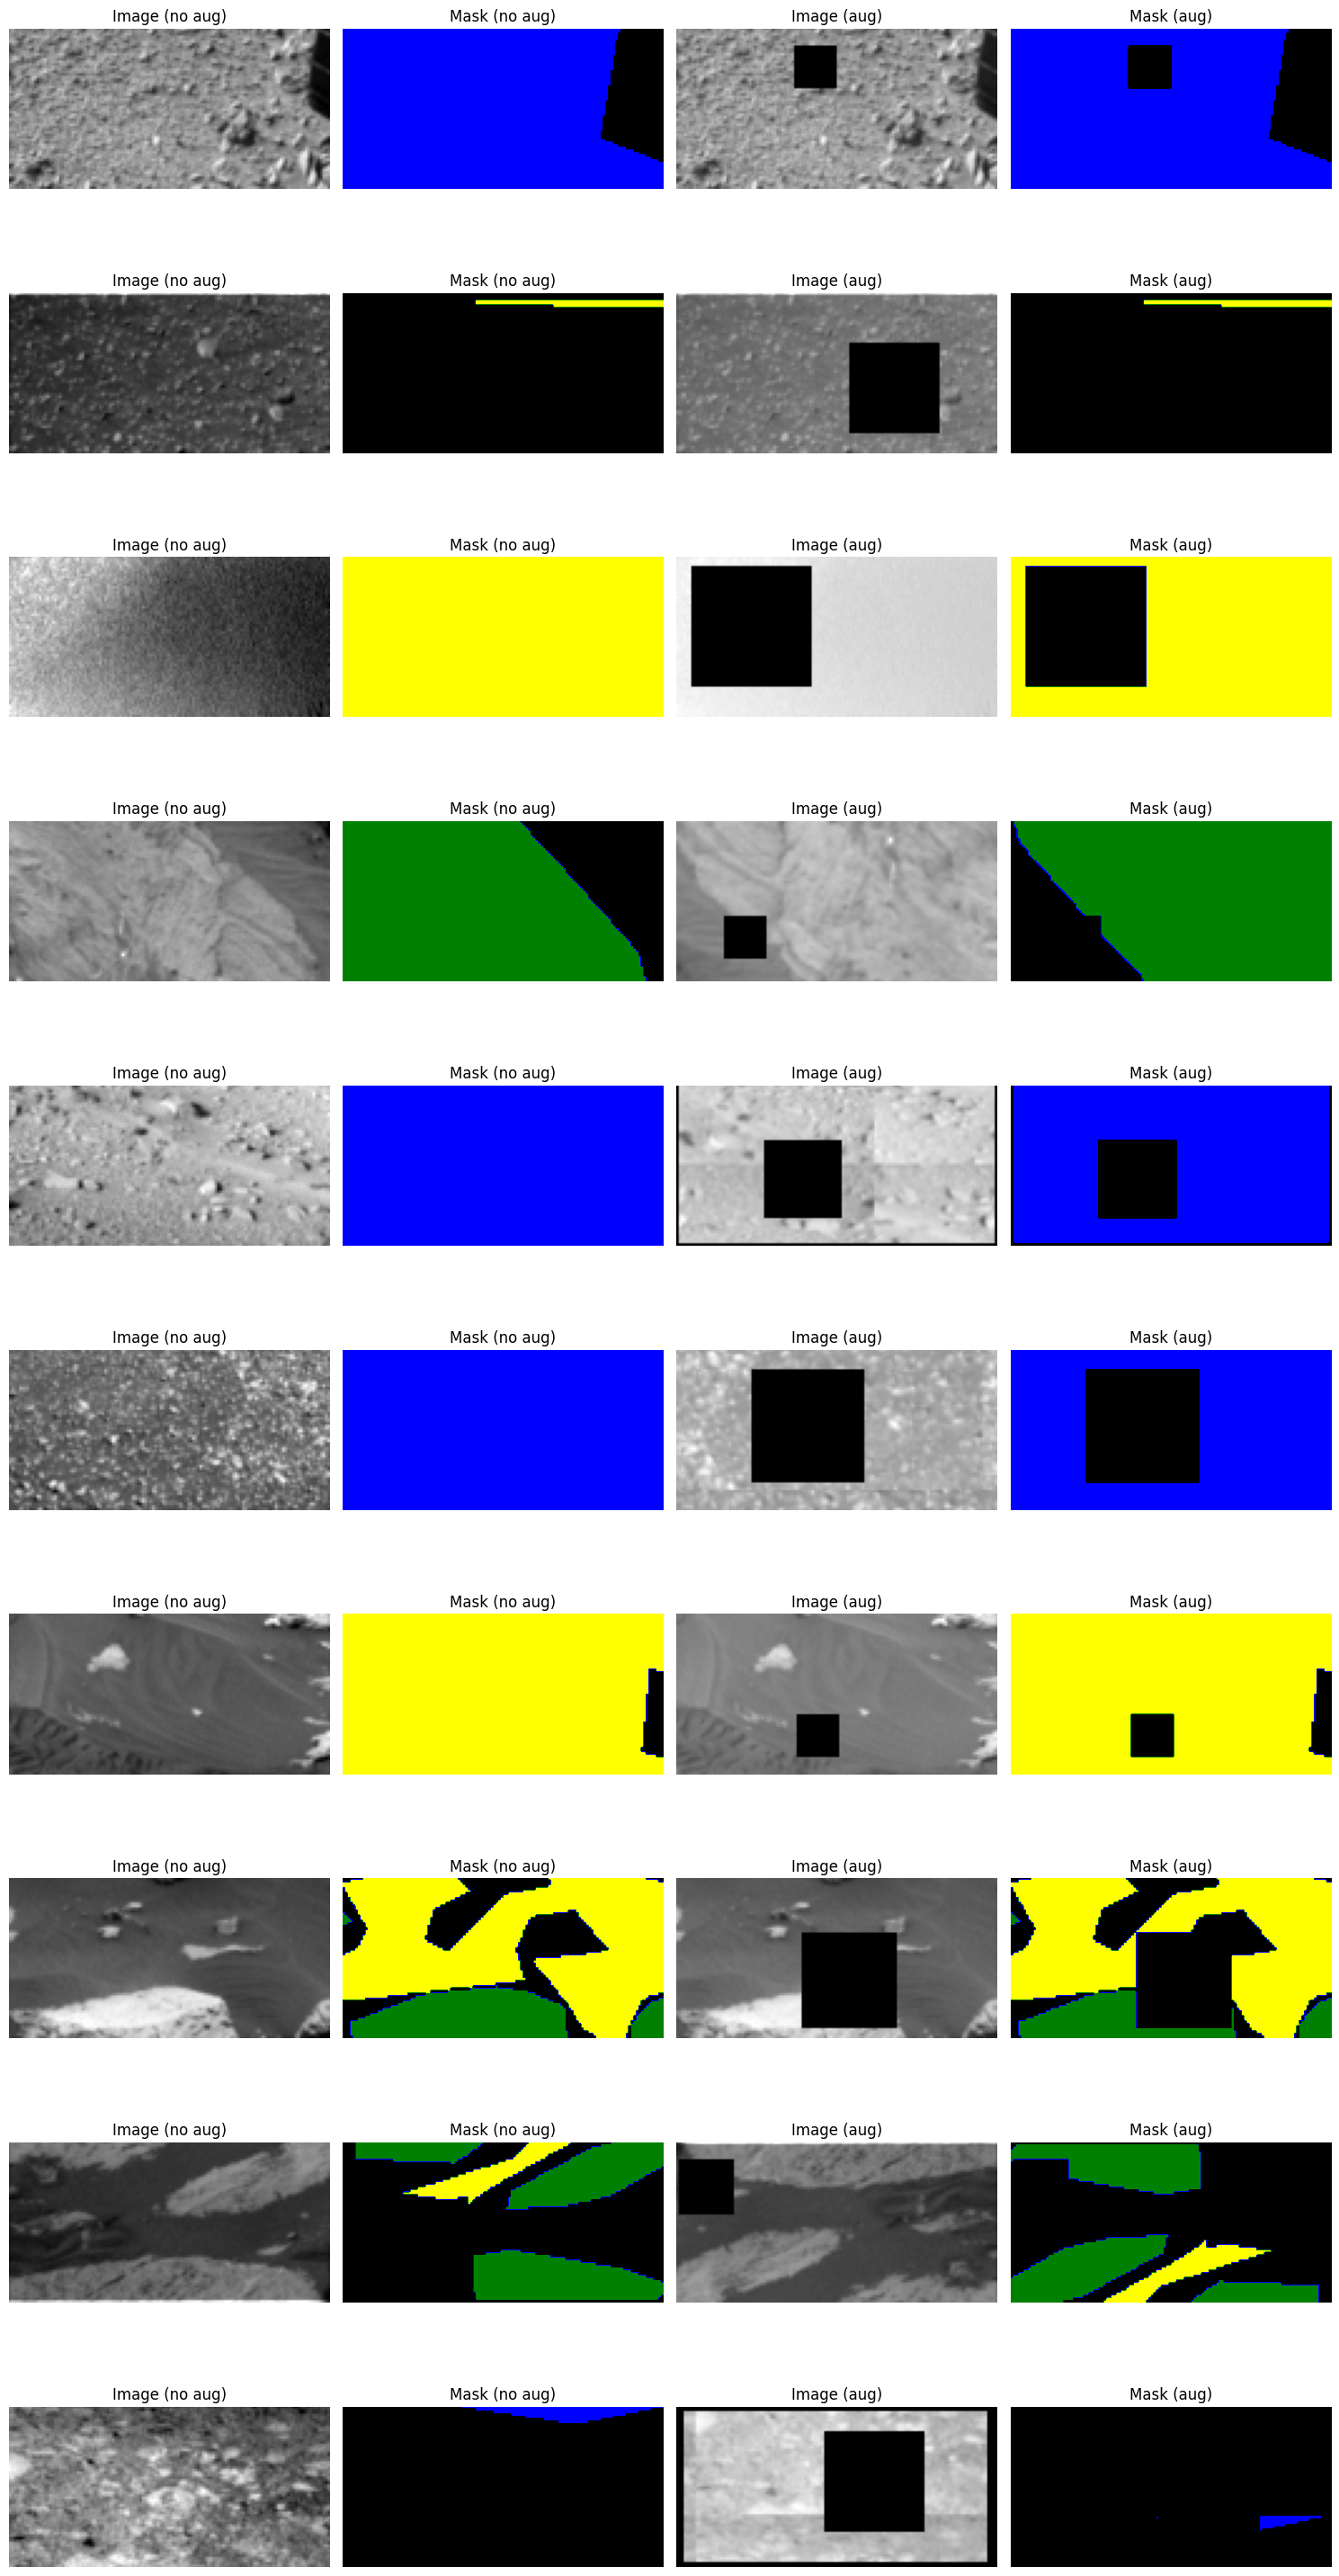

In [ ]:
plot_datasets(train_dataset_no_aug, train_dataset_aug, num_samples = 10)

# Dataset Creation

In [ ]:
train_dataset = to_dataset(X_train, y_train, augmentation = True, duplicate = True, cycles = 1)
val_dataset = to_dataset(X_val, y_val, augmentation = False, duplicate = False)

# Model

In [ ]:
num_classes = 5
epoch = 250
patience = 40 # 20

In [ ]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x

In [ ]:
def get_unet_model(input_shape=(64, 128, 1), num_classes=num_classes, seed=seed, activation='relu'):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    convol_1 = unet_block(input_layer, 32, activation=activation, name='down_block1')
    d1 = tfkl.MaxPooling2D()(convol_1)

    convol_2 = unet_block(d1, 64, activation=activation, name='down_block2')
    d2 = tfkl.MaxPooling2D()(convol_2)

    convol_3 = unet_block(d2, 128, activation=activation, name='down_block3')
    d3 = tfkl.MaxPooling2D()(convol_3)

    convol_4 = unet_block(d3, 256, activation=activation, name='down_block4')
    d4 = tfkl.MaxPooling2D()(convol_4)

    # Bottleneck
    bottleneck = unet_block(d4, 512, activation=activation, name='bottleneck')

    u1 = tfkl.UpSampling2D()(bottleneck)
    u1 = tfkl.Concatenate()([u1, convol_4])
    conv_up_1 = unet_block(u1, 128, activation=activation, name='up_block1')


    u2 = tfkl.UpSampling2D()(conv_up_1)
    u2 = tfkl.Concatenate()([u2, convol_3])
    conv_up_2 = unet_block(u2, 128, activation=activation, name='up_block2')

    u3 = tfkl.UpSampling2D()(conv_up_2)
    u3 = tfkl.Concatenate()([u3, convol_2])
    conv_up_3 = unet_block(u3, 64, activation=activation, name='up_block3')

    u4 = tfkl.UpSampling2D()(conv_up_3)
    u4 = tfkl.Concatenate()([u4, convol_1])
    conv_up_4 = unet_block(u4, 32, activation=activation, name='up_block4')

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(conv_up_4)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model

In [ ]:
model = get_unet_model(activation='leaky_relu')

## MIOU

In [ ]:
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=[0], name="mean_iou", dtype=None, **kwargs):
        """
        Aggiunto **kwargs per gestire parametri inattesi come `ignore_class`.
        """
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.argmax(y_pred, axis=-1)
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        return super().update_state(y_true, y_pred, sample_weight)

# Registra la classe personalizzata
tf.keras.utils.get_custom_objects()["MeanIntersectionOverUnion"] = MeanIntersectionOverUnion

## Visualization Callback

In [ ]:
from matplotlib.colors import ListedColormap

class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, dataset, frequency=5, num_classes=2):
        super().__init__()
        self.dataset = dataset
        self.frequency = frequency
        self.num_classes = num_classes
        self.dataset_iter = iter(dataset)  # Crea un iteratore per accedere ai dati

        # Crea la mappa di colori per visualizzare le maschere
        # Aggiungi qui i colori per ogni classe
        colors = ['black', 'blue', 'green', 'yellow', 'red']  # Colori per 5 classi
        self.cmap = ListedColormap(colors)

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualizza solo ogni "frequency" epochs
            try:
                # Estrai un batch di dati
                image, label = next(self.dataset_iter)
            except StopIteration:
                # Ricrea l'iteratore se i dati sono terminati
                self.dataset_iter = iter(self.dataset)
                image, label = next(self.dataset_iter)

            # Prepara i dati per la predizione
            image = tf.expand_dims(image[0], 0)  # Estrai una sola immagine dal batch
            label = label[0]  # Etichetta corrispondente
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            plt.figure(figsize=(16, 4))

            # Immagine di input
            plt.subplot(1, 3, 1)
            plt.imshow(image[0], cmap="gray")
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth (maschera) con la mappa di colori
            plt.subplot(1, 3, 2)
            plt.imshow(label.numpy(), cmap=self.cmap, vmin=0, vmax=self.num_classes-1)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Predizione con la mappa di colori
            plt.subplot(1, 3, 3)
            plt.imshow(y_pred[0], cmap=self.cmap, vmin=0, vmax=self.num_classes-1)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()


## Early Stopping Callback

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

viz_callback = VizCallback(val_dataset, frequency=5, num_classes=5)


## Compile

In [ ]:
import keras.backend as K

# 1. Dice Loss
def dice_loss(y_true, y_pred, smooth=1e-6):
    # Trasformiamo la maschera non one-hot in una one-hot, se necessario
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    intersection = K.sum(y_true * y_pred, axis=(1, 2))
    union = K.sum(y_true, axis=(1, 2)) + K.sum(y_pred, axis=(1, 2))

    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - K.mean(dice)

# 2. Focal Loss with Inverse Frequency Weighting
def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0, smooth=1e-6):
    # Trasformiamo le maschere non one-hot in una one-hot
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Calcoliamo la probabilità per ogni classe
    epsilon = tf.keras.backend.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

    # Calcoliamo il termine focalizzato
    cross_entropy = -y_true * K.log(y_pred)
    loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
    return K.mean(K.sum(loss, axis=-1))

# 3. Boundary Loss
def boundary_loss(y_true, y_pred, smooth=1e-6):
    # Calcoliamo i bordi della maschera
    kernel = tf.ones([3, 3, 1, 1])  # Kernel per il filtro
    y_true_boundary = tf.image.sobel_edges(y_true)  # Trova i bordi
    y_pred_boundary = tf.image.sobel_edges(y_pred)

    boundary_diff = K.abs(y_true_boundary - y_pred_boundary)
    return K.mean(boundary_diff)

# 4. Combinazione delle perdite
def combined_loss(y_true, y_pred, a=1.0, b=1.0, c=1.0):
    dice = dice_loss(y_true, y_pred)
    focal = focal_loss(y_true, y_pred)
    boundary = boundary_loss(y_true, y_pred)

    return a * dice + b * focal + c * boundary

# Esempio di serializzazione in un modello .keras
def get_custom_loss(a=1.0, b=1.0, c=1.0):
    def loss(y_true, y_pred):
        return combined_loss(y_true, y_pred, a, b, c)
    return loss


In [ ]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.AdamW(0.001),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])]
)

## Training

Epoch 1/250


I0000 00:00:1733844984.540907      85 service.cc:145] XLA service 0x7bfa50016c30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733844984.540981      85 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
W0000 00:00:1733844990.359148      85 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


  2/126 ━━━━━━━━━━━━━━━━━━━━ 11s 92ms/step - accuracy: 0.2215 - loss: 1.9376 - mean_iou: 0.1034   

I0000 00:00:1733845005.181962      85 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.5473 - loss: 1.1906 - mean_iou: 0.2309

W0000 00:00:1733845016.790924      85 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.5478 - loss: 1.1891 - mean_iou: 0.2313

W0000 00:00:1733845031.669356      84 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1733845037.371991      85 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


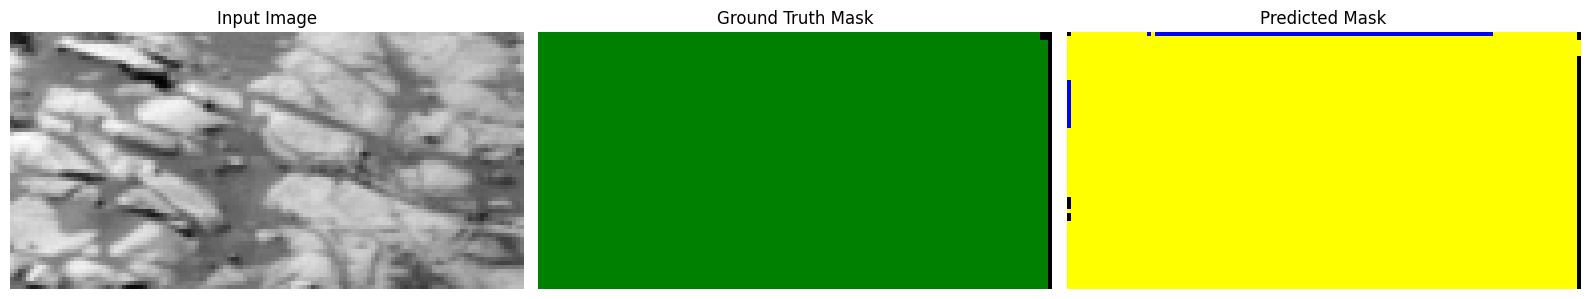

126/126 ━━━━━━━━━━━━━━━━━━━━ 69s 297ms/step - accuracy: 0.5484 - loss: 1.1877 - mean_iou: 0.2317 - val_accuracy: 0.2014 - val_loss: 10.7595 - val_mean_iou: 0.0543
Epoch 2/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.6778 - loss: 0.8122 - mean_iou: 0.3289 - val_accuracy: 0.1987 - val_loss: 4.9126 - val_mean_iou: 0.0530
Epoch 3/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.7125 - loss: 0.7267 - mean_iou: 0.3643 - val_accuracy: 0.2592 - val_loss: 2.5861 - val_mean_iou: 0.0793
Epoch 4/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.7317 - loss: 0.6858 - mean_iou: 0.3860 - val_accuracy: 0.3891 - val_loss: 2.1821 - val_mean_iou: 0.1715
Epoch 5/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.7522 - loss: 0.6408 - mean_iou: 0.4102 - val_accuracy: 0.5410 - val_loss: 1.3673 - val_mean_iou: 0.2603
Epoch 6/250
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7593 - loss: 0.6182 - mean_iou: 0.4176

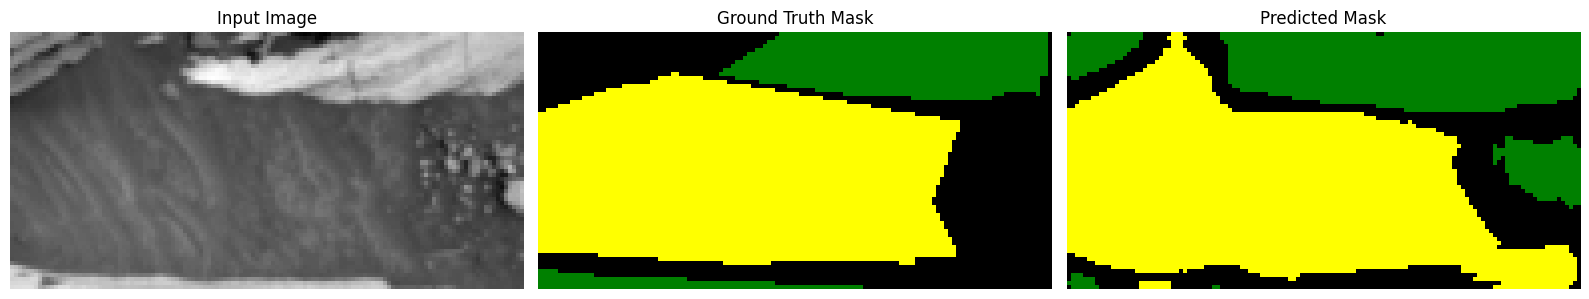

126/126 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - accuracy: 0.7594 - loss: 0.6181 - mean_iou: 0.4176 - val_accuracy: 0.6921 - val_loss: 0.8433 - val_mean_iou: 0.4344
Epoch 7/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.7706 - loss: 0.5943 - mean_iou: 0.4302 - val_accuracy: 0.7051 - val_loss: 0.7601 - val_mean_iou: 0.3932
Epoch 8/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.7679 - loss: 0.6023 - mean_iou: 0.4253 - val_accuracy: 0.6899 - val_loss: 0.7997 - val_mean_iou: 0.3780
Epoch 9/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.7788 - loss: 0.5773 - mean_iou: 0.4395 - val_accuracy: 0.6067 - val_loss: 1.1578 - val_mean_iou: 0.2613
Epoch 10/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.7857 - loss: 0.5566 - mean_iou: 0.4468 - val_accuracy: 0.7261 - val_loss: 0.8091 - val_mean_iou: 0.4245
Epoch 11/250
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7879 - loss: 0.5465 - mean_iou: 0.4508

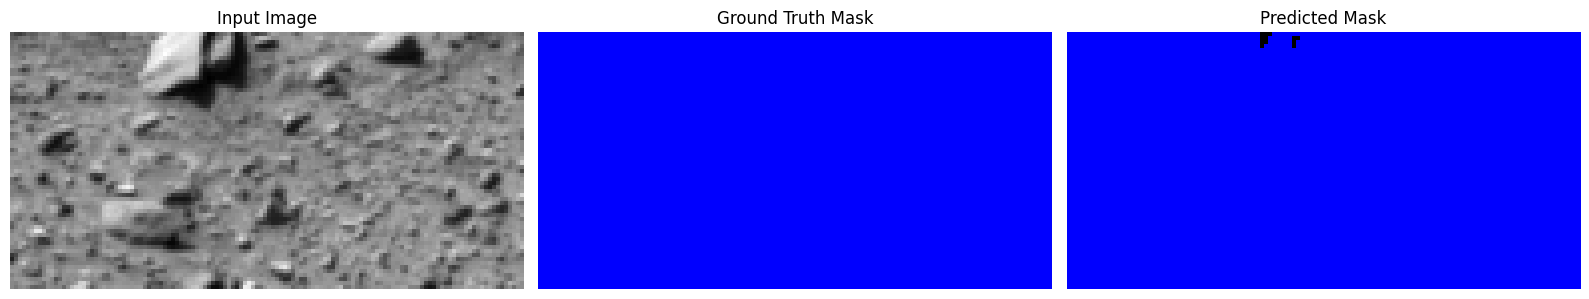

126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.7880 - loss: 0.5465 - mean_iou: 0.4508 - val_accuracy: 0.7122 - val_loss: 0.7943 - val_mean_iou: 0.3937
Epoch 12/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.7924 - loss: 0.5392 - mean_iou: 0.4529 - val_accuracy: 0.6907 - val_loss: 0.9049 - val_mean_iou: 0.3610
Epoch 13/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.7994 - loss: 0.5198 - mean_iou: 0.4626 - val_accuracy: 0.5769 - val_loss: 1.4004 - val_mean_iou: 0.2762
Epoch 14/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.8015 - loss: 0.5137 - mean_iou: 0.4647 - val_accuracy: 0.7599 - val_loss: 0.6431 - val_mean_iou: 0.4600
Epoch 15/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.8041 - loss: 0.5086 - mean_iou: 0.4685 - val_accuracy: 0.3986 - val_loss: 2.2951 - val_mean_iou: 0.1416
Epoch 16/250
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8081 - loss: 0.4947 - mean_iou: 0.4722

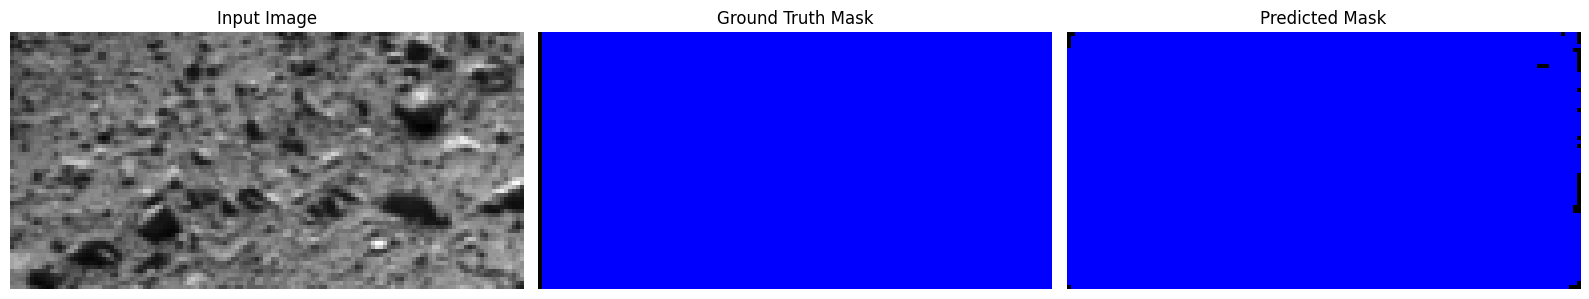

126/126 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.8082 - loss: 0.4946 - mean_iou: 0.4722 - val_accuracy: 0.6244 - val_loss: 0.9803 - val_mean_iou: 0.3112
Epoch 17/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.8119 - loss: 0.4801 - mean_iou: 0.4781 - val_accuracy: 0.6952 - val_loss: 1.0547 - val_mean_iou: 0.3828
Epoch 18/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.8080 - loss: 0.4917 - mean_iou: 0.4723 - val_accuracy: 0.6656 - val_loss: 1.0016 - val_mean_iou: 0.3543
Epoch 19/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.8124 - loss: 0.4825 - mean_iou: 0.4796 - val_accuracy: 0.7774 - val_loss: 0.6001 - val_mean_iou: 0.4808
Epoch 20/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.8144 - loss: 0.4708 - mean_iou: 0.4805 - val_accuracy: 0.7472 - val_loss: 0.7615 - val_mean_iou: 0.4531
Epoch 21/250
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8201 - loss: 0.4609 - mean_iou: 0.4872

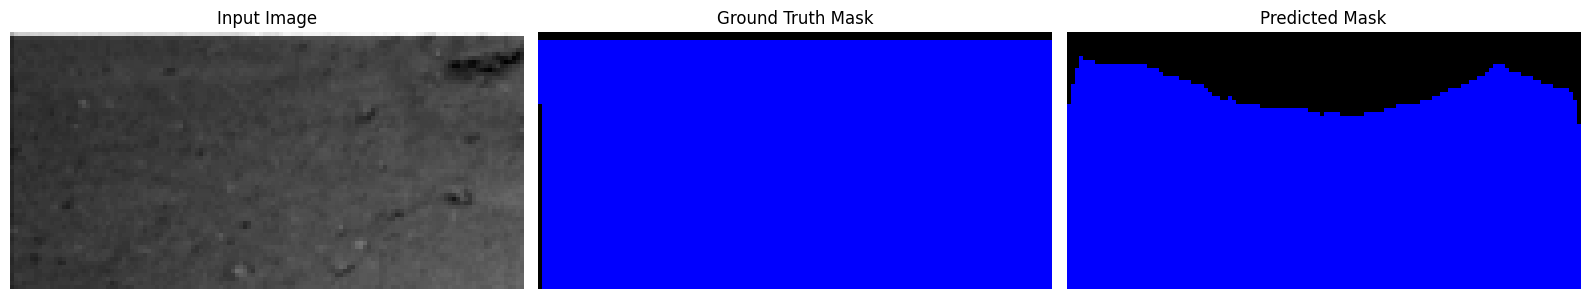

126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.8202 - loss: 0.4609 - mean_iou: 0.4871 - val_accuracy: 0.7492 - val_loss: 0.6973 - val_mean_iou: 0.4298
Epoch 22/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.8219 - loss: 0.4555 - mean_iou: 0.4903 - val_accuracy: 0.7316 - val_loss: 0.7474 - val_mean_iou: 0.4126
Epoch 23/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.8231 - loss: 0.4541 - mean_iou: 0.4897 - val_accuracy: 0.7789 - val_loss: 0.6616 - val_mean_iou: 0.4772
Epoch 24/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.8280 - loss: 0.4380 - mean_iou: 0.4967 - val_accuracy: 0.7068 - val_loss: 0.9469 - val_mean_iou: 0.3778
Epoch 25/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.8304 - loss: 0.4337 - mean_iou: 0.4987 - val_accuracy: 0.6574 - val_loss: 0.9752 - val_mean_iou: 0.3348
Epoch 26/250
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8311 - loss: 0.4338 - mean_iou: 0.5117

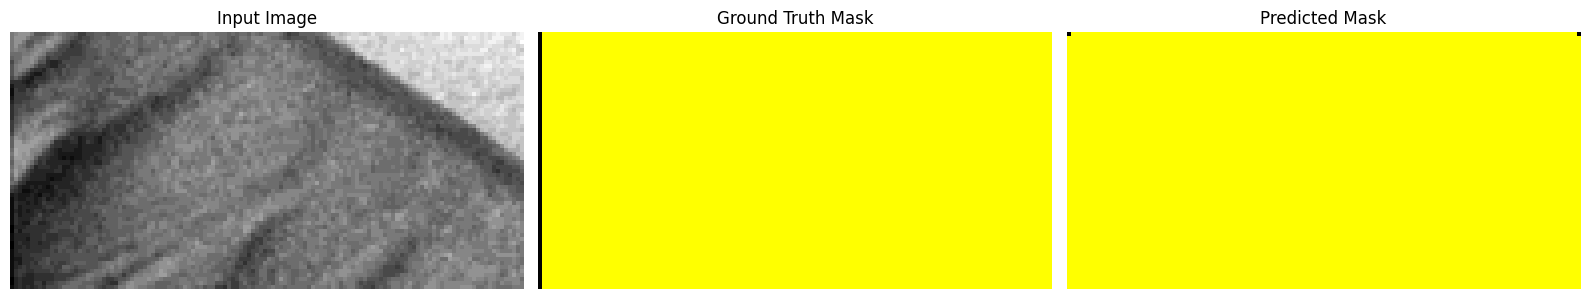

126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.8311 - loss: 0.4337 - mean_iou: 0.5115 - val_accuracy: 0.6961 - val_loss: 0.8863 - val_mean_iou: 0.3724
Epoch 27/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.8343 - loss: 0.4247 - mean_iou: 0.5171 - val_accuracy: 0.7592 - val_loss: 0.6802 - val_mean_iou: 0.4515
Epoch 28/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.8333 - loss: 0.4243 - mean_iou: 0.5019 - val_accuracy: 0.7134 - val_loss: 0.8967 - val_mean_iou: 0.3817
Epoch 29/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.8358 - loss: 0.4166 - mean_iou: 0.5057 - val_accuracy: 0.7488 - val_loss: 0.7836 - val_mean_iou: 0.4457
Epoch 30/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.8402 - loss: 0.4080 - mean_iou: 0.5235 - val_accuracy: 0.7848 - val_loss: 0.5944 - val_mean_iou: 0.4776
Epoch 31/250
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8389 - loss: 0.4086 - mean_iou: 0.5256

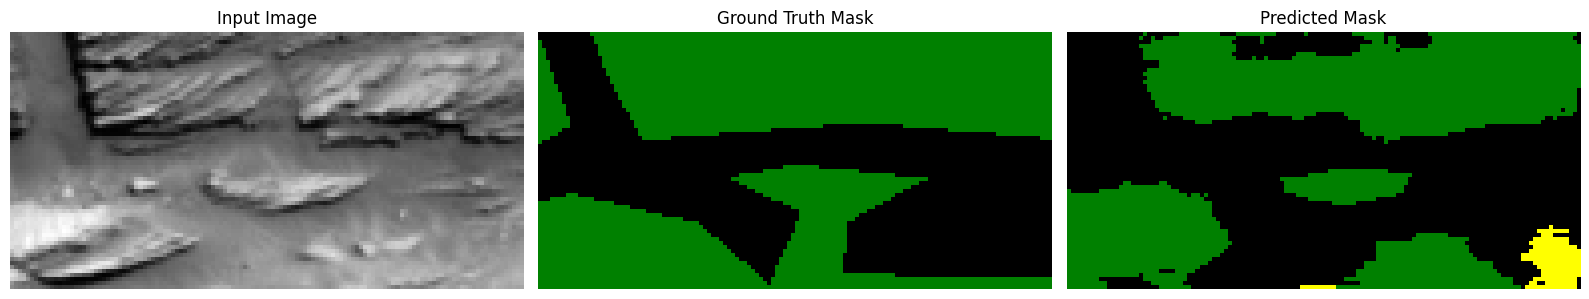

126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.8389 - loss: 0.4086 - mean_iou: 0.5255 - val_accuracy: 0.7339 - val_loss: 0.7551 - val_mean_iou: 0.4172
Epoch 32/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.8447 - loss: 0.3966 - mean_iou: 0.5200 - val_accuracy: 0.7636 - val_loss: 0.6722 - val_mean_iou: 0.4590
Epoch 33/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.8411 - loss: 0.4046 - mean_iou: 0.5124 - val_accuracy: 0.7028 - val_loss: 0.7990 - val_mean_iou: 0.3902
Epoch 34/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.8464 - loss: 0.3932 - mean_iou: 0.5255 - val_accuracy: 0.7362 - val_loss: 0.7369 - val_mean_iou: 0.4184
Epoch 35/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.8482 - loss: 0.3876 - mean_iou: 0.5203 - val_accuracy: 0.7590 - val_loss: 0.7110 - val_mean_iou: 0.4377
Epoch 36/250
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8485 - loss: 0.3837 - mean_iou: 0.5185

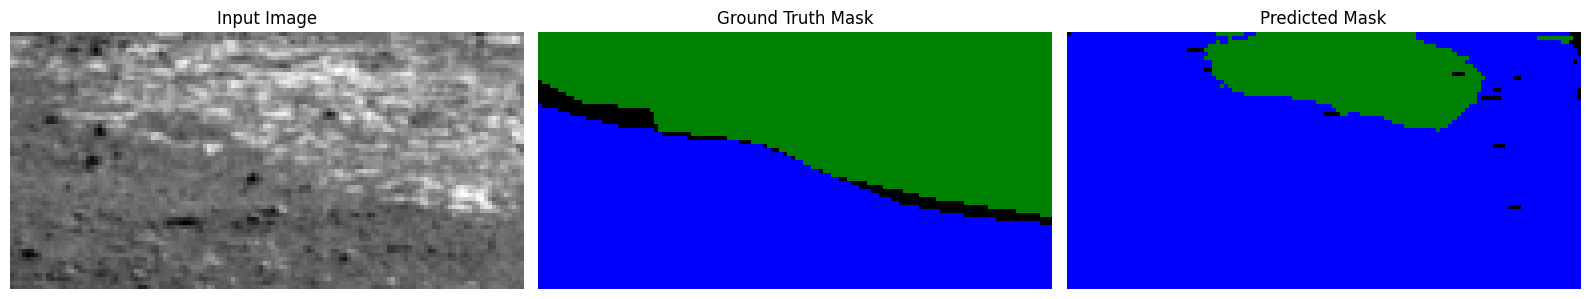

126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.8485 - loss: 0.3837 - mean_iou: 0.5185 - val_accuracy: 0.7782 - val_loss: 0.6068 - val_mean_iou: 0.4722
Epoch 37/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.8515 - loss: 0.3785 - mean_iou: 0.5261 - val_accuracy: 0.7095 - val_loss: 0.8059 - val_mean_iou: 0.4059
Epoch 38/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.8518 - loss: 0.3807 - mean_iou: 0.5342 - val_accuracy: 0.7120 - val_loss: 0.8460 - val_mean_iou: 0.3943
Epoch 39/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.8536 - loss: 0.3747 - mean_iou: 0.5308 - val_accuracy: 0.7597 - val_loss: 0.7820 - val_mean_iou: 0.4568
Epoch 40/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.8583 - loss: 0.3653 - mean_iou: 0.5342 - val_accuracy: 0.7322 - val_loss: 0.7443 - val_mean_iou: 0.4204
Epoch 41/250
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8570 - loss: 0.3699 - mean_iou: 0.5351

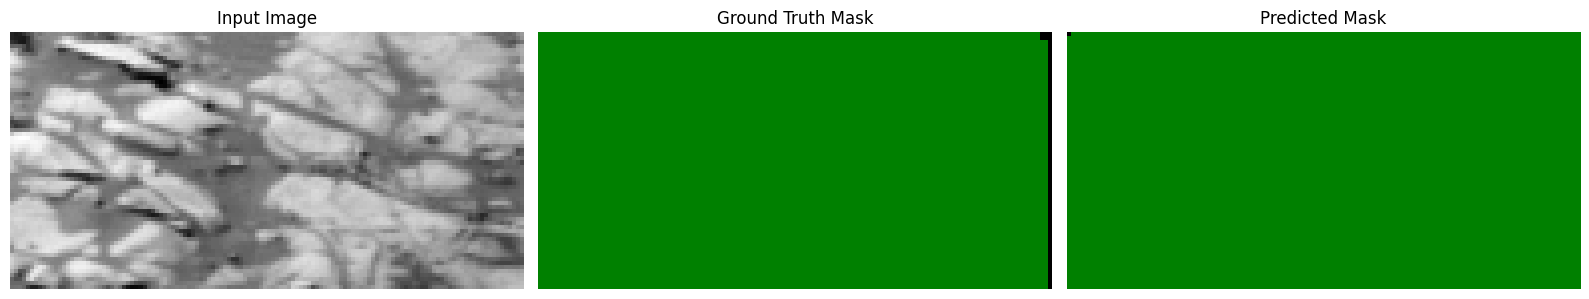

126/126 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.8570 - loss: 0.3699 - mean_iou: 0.5351 - val_accuracy: 0.6831 - val_loss: 0.8401 - val_mean_iou: 0.3862
Epoch 42/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.8582 - loss: 0.3659 - mean_iou: 0.5324 - val_accuracy: 0.6855 - val_loss: 0.9378 - val_mean_iou: 0.3569
Epoch 43/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.8562 - loss: 0.3729 - mean_iou: 0.5318 - val_accuracy: 0.6099 - val_loss: 1.2236 - val_mean_iou: 0.2988
Epoch 44/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.8625 - loss: 0.3543 - mean_iou: 0.5395 - val_accuracy: 0.7701 - val_loss: 0.6506 - val_mean_iou: 0.4598
Epoch 45/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.8625 - loss: 0.3528 - mean_iou: 0.5435 - val_accuracy: 0.7087 - val_loss: 0.8451 - val_mean_iou: 0.3937
Epoch 46/250
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8632 - loss: 0.3517 - mean_iou: 0.5384

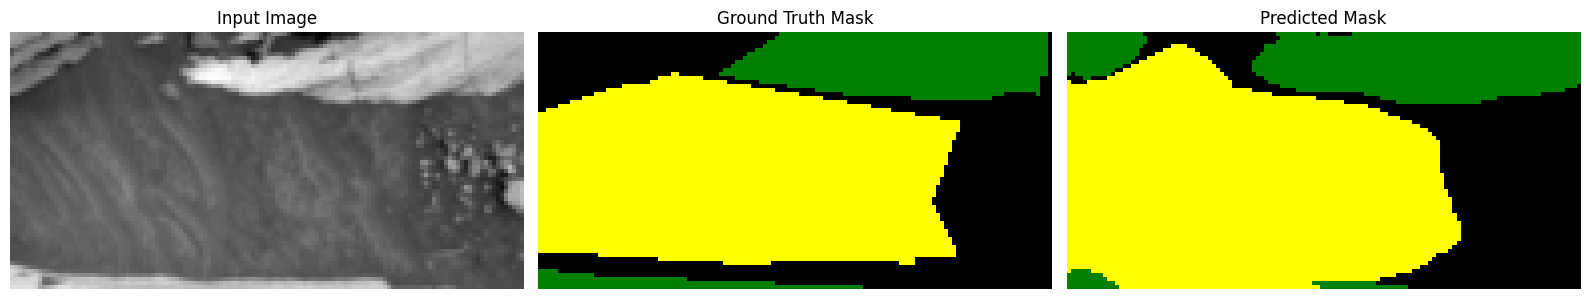

126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.8632 - loss: 0.3518 - mean_iou: 0.5383 - val_accuracy: 0.6456 - val_loss: 1.2765 - val_mean_iou: 0.3157
Epoch 47/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.8650 - loss: 0.3480 - mean_iou: 0.5408 - val_accuracy: 0.7886 - val_loss: 0.6424 - val_mean_iou: 0.4824
Epoch 48/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.8689 - loss: 0.3389 - mean_iou: 0.5460 - val_accuracy: 0.6668 - val_loss: 0.9753 - val_mean_iou: 0.3504
Epoch 49/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.8637 - loss: 0.3512 - mean_iou: 0.5380 - val_accuracy: 0.6168 - val_loss: 1.3715 - val_mean_iou: 0.3076
Epoch 50/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.8716 - loss: 0.3318 - mean_iou: 0.5529 - val_accuracy: 0.7863 - val_loss: 0.6787 - val_mean_iou: 0.4940
Epoch 51/250
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8696 - loss: 0.3366 - mean_iou: 0.5570

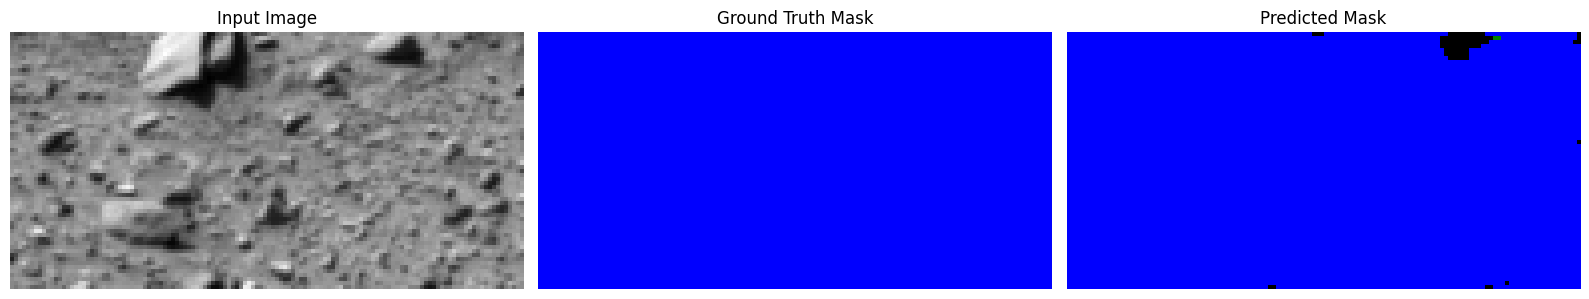

126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.8697 - loss: 0.3365 - mean_iou: 0.5569 - val_accuracy: 0.6799 - val_loss: 0.8500 - val_mean_iou: 0.3647
Epoch 52/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.8704 - loss: 0.3363 - mean_iou: 0.5493 - val_accuracy: 0.6970 - val_loss: 0.8581 - val_mean_iou: 0.3781
Epoch 53/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.8738 - loss: 0.3236 - mean_iou: 0.5529 - val_accuracy: 0.7530 - val_loss: 0.7233 - val_mean_iou: 0.4406
Epoch 54/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.8735 - loss: 0.3290 - mean_iou: 0.5546 - val_accuracy: 0.7638 - val_loss: 0.7822 - val_mean_iou: 0.4443
Epoch 55/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.8754 - loss: 0.3210 - mean_iou: 0.5584 - val_accuracy: 0.7711 - val_loss: 0.6746 - val_mean_iou: 0.4614
Epoch 56/250
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8778 - loss: 0.3139 - mean_iou: 0.5627

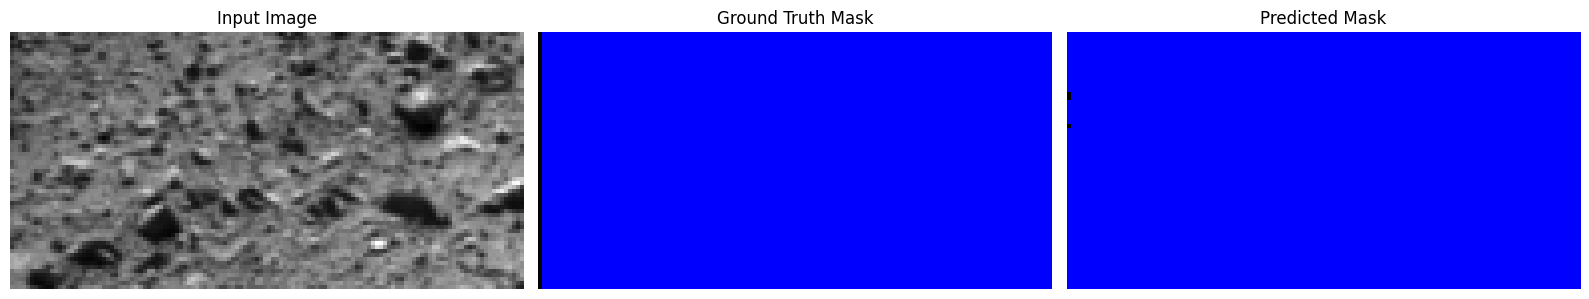

126/126 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - accuracy: 0.8778 - loss: 0.3139 - mean_iou: 0.5625 - val_accuracy: 0.7560 - val_loss: 0.7112 - val_mean_iou: 0.4480
Epoch 57/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.8799 - loss: 0.3101 - mean_iou: 0.5700 - val_accuracy: 0.7464 - val_loss: 0.7845 - val_mean_iou: 0.4468
Epoch 58/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.8779 - loss: 0.3160 - mean_iou: 0.5671 - val_accuracy: 0.7705 - val_loss: 0.6725 - val_mean_iou: 0.4618
Epoch 59/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.8784 - loss: 0.3150 - mean_iou: 0.5550 - val_accuracy: 0.7803 - val_loss: 0.6932 - val_mean_iou: 0.4705
Epoch 60/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.8799 - loss: 0.3132 - mean_iou: 0.5652 - val_accuracy: 0.6768 - val_loss: 0.9912 - val_mean_iou: 0.3498
Epoch 61/250
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8803 - loss: 0.3112 - mean_iou: 0.5634

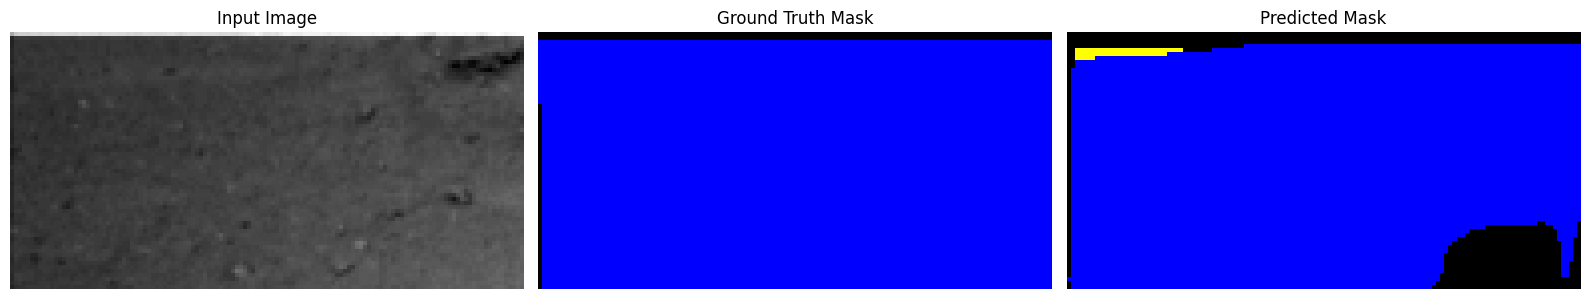

126/126 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - accuracy: 0.8803 - loss: 0.3111 - mean_iou: 0.5634 - val_accuracy: 0.7711 - val_loss: 0.6668 - val_mean_iou: 0.4585
Epoch 62/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.8829 - loss: 0.3025 - mean_iou: 0.5758 - val_accuracy: 0.7914 - val_loss: 0.6384 - val_mean_iou: 0.4795
Epoch 63/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.8854 - loss: 0.2968 - mean_iou: 0.5751 - val_accuracy: 0.7992 - val_loss: 0.6571 - val_mean_iou: 0.4956
Epoch 64/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.8851 - loss: 0.2994 - mean_iou: 0.5669 - val_accuracy: 0.7820 - val_loss: 0.6958 - val_mean_iou: 0.4756
Epoch 65/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.8858 - loss: 0.2968 - mean_iou: 0.5717 - val_accuracy: 0.7941 - val_loss: 0.6465 - val_mean_iou: 0.4885
Epoch 66/250
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8891 - loss: 0.2892 - mean_iou: 0.5819

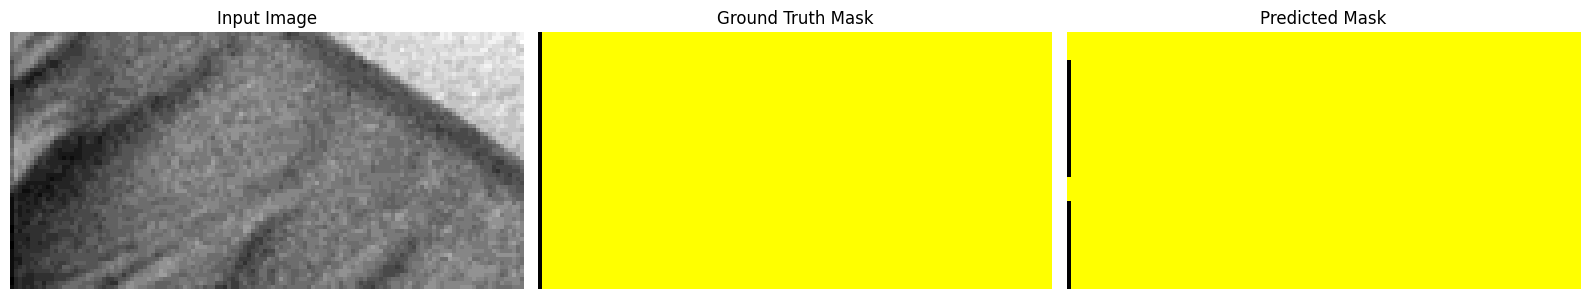

126/126 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - accuracy: 0.8891 - loss: 0.2893 - mean_iou: 0.5817 - val_accuracy: 0.7741 - val_loss: 0.6644 - val_mean_iou: 0.4647
Epoch 67/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.8860 - loss: 0.2910 - mean_iou: 0.5733 - val_accuracy: 0.7747 - val_loss: 0.6725 - val_mean_iou: 0.4643
Epoch 68/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.8866 - loss: 0.2926 - mean_iou: 0.5682 - val_accuracy: 0.7471 - val_loss: 0.7544 - val_mean_iou: 0.4399
Epoch 69/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.8880 - loss: 0.2914 - mean_iou: 0.5689 - val_accuracy: 0.7451 - val_loss: 0.8357 - val_mean_iou: 0.4254
Epoch 70/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.8903 - loss: 0.2831 - mean_iou: 0.5775 - val_accuracy: 0.7767 - val_loss: 0.6942 - val_mean_iou: 0.4643
Epoch 71/250
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8916 - loss: 0.2815 - mean_iou: 0.5808

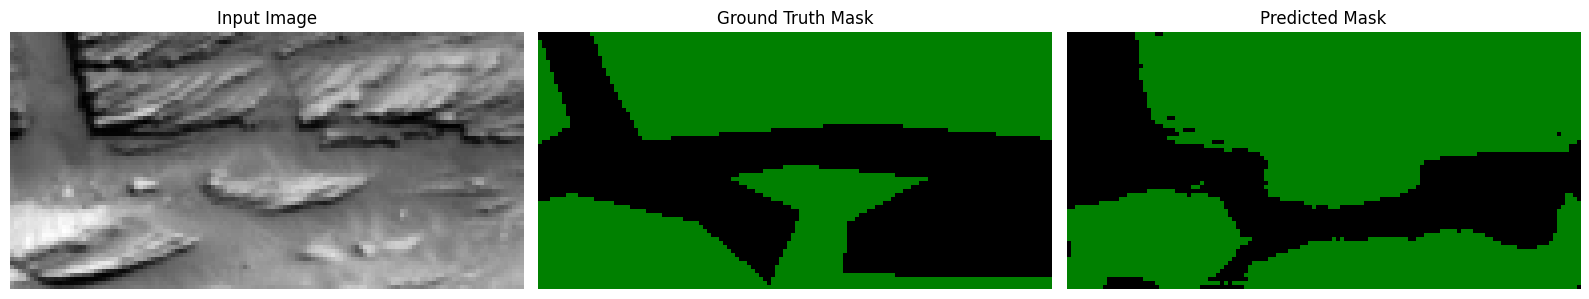

126/126 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - accuracy: 0.8916 - loss: 0.2815 - mean_iou: 0.5807 - val_accuracy: 0.6717 - val_loss: 1.0181 - val_mean_iou: 0.3671
Epoch 72/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.8915 - loss: 0.2835 - mean_iou: 0.5728 - val_accuracy: 0.7729 - val_loss: 0.7267 - val_mean_iou: 0.4540
Epoch 73/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.8946 - loss: 0.2738 - mean_iou: 0.5793 - val_accuracy: 0.7702 - val_loss: 0.7142 - val_mean_iou: 0.4581
Epoch 74/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.8960 - loss: 0.2716 - mean_iou: 0.5939 - val_accuracy: 0.7801 - val_loss: 0.6786 - val_mean_iou: 0.4734
Epoch 75/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.8955 - loss: 0.2734 - mean_iou: 0.5858 - val_accuracy: 0.7879 - val_loss: 0.6857 - val_mean_iou: 0.4969
Epoch 76/250
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8975 - loss: 0.2666 - mean_iou: 0.5751

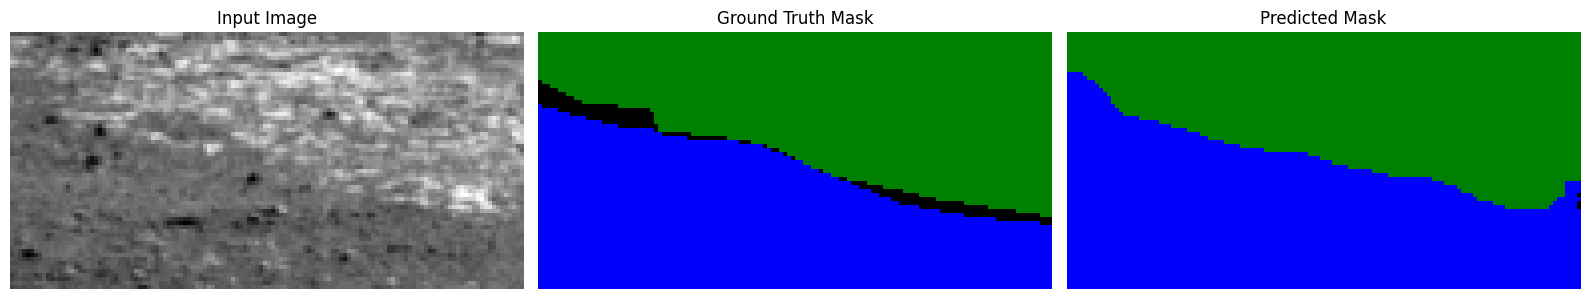

126/126 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.8974 - loss: 0.2668 - mean_iou: 0.5750 - val_accuracy: 0.7863 - val_loss: 0.7347 - val_mean_iou: 0.4868
Epoch 77/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.8967 - loss: 0.2694 - mean_iou: 0.5887 - val_accuracy: 0.7867 - val_loss: 0.6988 - val_mean_iou: 0.5095
Epoch 78/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.8956 - loss: 0.2725 - mean_iou: 0.5755 - val_accuracy: 0.7817 - val_loss: 0.6558 - val_mean_iou: 0.4745
Epoch 79/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.9008 - loss: 0.2590 - mean_iou: 0.5858 - val_accuracy: 0.7404 - val_loss: 0.8213 - val_mean_iou: 0.4314
Epoch 80/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.9032 - loss: 0.2570 - mean_iou: 0.5944 - val_accuracy: 0.7509 - val_loss: 0.8320 - val_mean_iou: 0.4483
Epoch 81/250
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8992 - loss: 0.2607 - mean_iou: 0.6028

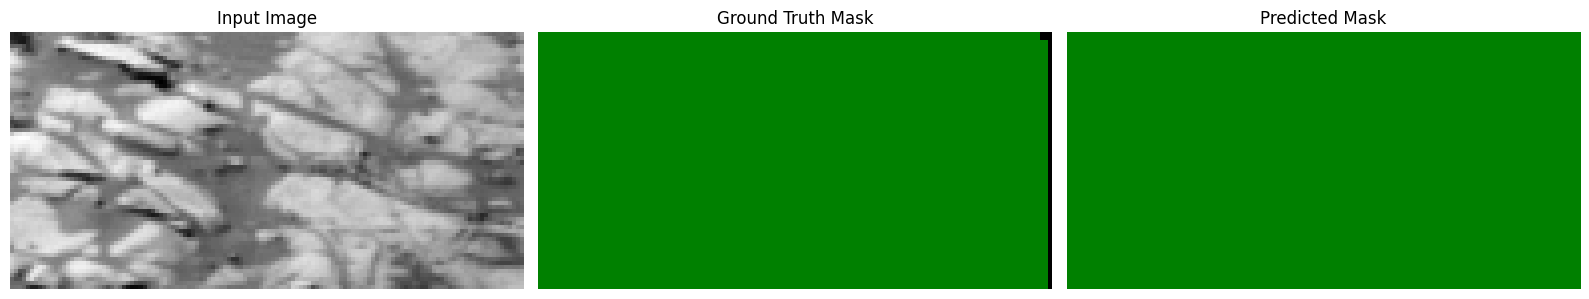

126/126 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - accuracy: 0.8992 - loss: 0.2607 - mean_iou: 0.6026 - val_accuracy: 0.7713 - val_loss: 0.7615 - val_mean_iou: 0.5000
Epoch 82/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.9015 - loss: 0.2567 - mean_iou: 0.5933 - val_accuracy: 0.7845 - val_loss: 0.6828 - val_mean_iou: 0.4968
Epoch 83/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.9041 - loss: 0.2501 - mean_iou: 0.6088 - val_accuracy: 0.7509 - val_loss: 0.8126 - val_mean_iou: 0.4559
Epoch 84/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.9012 - loss: 0.2581 - mean_iou: 0.5919 - val_accuracy: 0.7513 - val_loss: 0.9678 - val_mean_iou: 0.4518
Epoch 85/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.9040 - loss: 0.2532 - mean_iou: 0.6015 - val_accuracy: 0.7589 - val_loss: 0.8753 - val_mean_iou: 0.4431
Epoch 86/250
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9012 - loss: 0.2610 - mean_iou: 0.5929

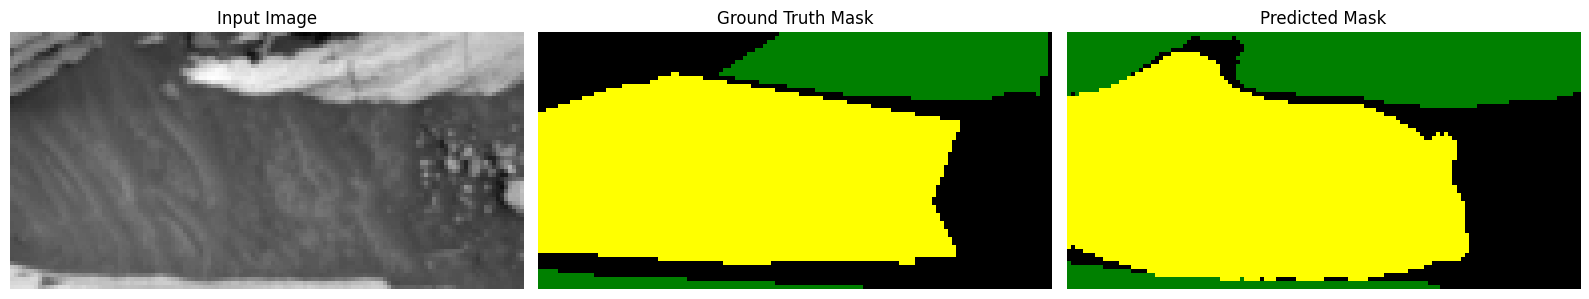

126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.9012 - loss: 0.2609 - mean_iou: 0.5930 - val_accuracy: 0.7606 - val_loss: 0.7738 - val_mean_iou: 0.4546
Epoch 87/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.9057 - loss: 0.2454 - mean_iou: 0.6071 - val_accuracy: 0.7438 - val_loss: 0.8485 - val_mean_iou: 0.4258
Epoch 88/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.9083 - loss: 0.2396 - mean_iou: 0.6117 - val_accuracy: 0.7395 - val_loss: 0.8545 - val_mean_iou: 0.4389
Epoch 89/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.9080 - loss: 0.2413 - mean_iou: 0.6038 - val_accuracy: 0.7726 - val_loss: 0.7863 - val_mean_iou: 0.4663
Epoch 90/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.9077 - loss: 0.2407 - mean_iou: 0.6195 - val_accuracy: 0.7827 - val_loss: 0.7356 - val_mean_iou: 0.4784
Epoch 91/250
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9049 - loss: 0.2487 - mean_iou: 0.6165

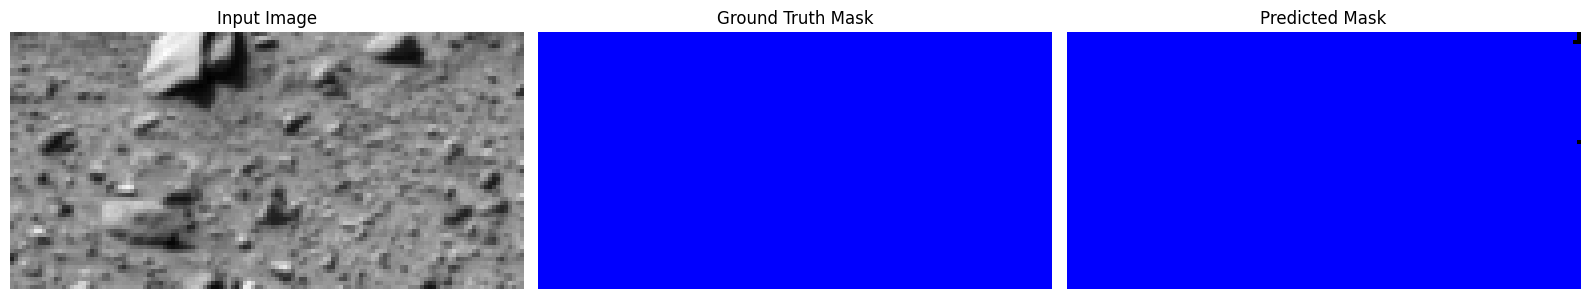

126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.9049 - loss: 0.2486 - mean_iou: 0.6165 - val_accuracy: 0.7564 - val_loss: 0.7134 - val_mean_iou: 0.4471
Epoch 92/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.9095 - loss: 0.2373 - mean_iou: 0.6152 - val_accuracy: 0.7373 - val_loss: 0.8135 - val_mean_iou: 0.4252
Epoch 93/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.9018 - loss: 0.2558 - mean_iou: 0.6123 - val_accuracy: 0.7783 - val_loss: 0.7298 - val_mean_iou: 0.4771
Epoch 94/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.9092 - loss: 0.2375 - mean_iou: 0.6117 - val_accuracy: 0.7118 - val_loss: 0.8425 - val_mean_iou: 0.4106
Epoch 95/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.9091 - loss: 0.2362 - mean_iou: 0.6226 - val_accuracy: 0.6595 - val_loss: 1.2487 - val_mean_iou: 0.3499
Epoch 96/250
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9128 - loss: 0.2296 - mean_iou: 0.6111

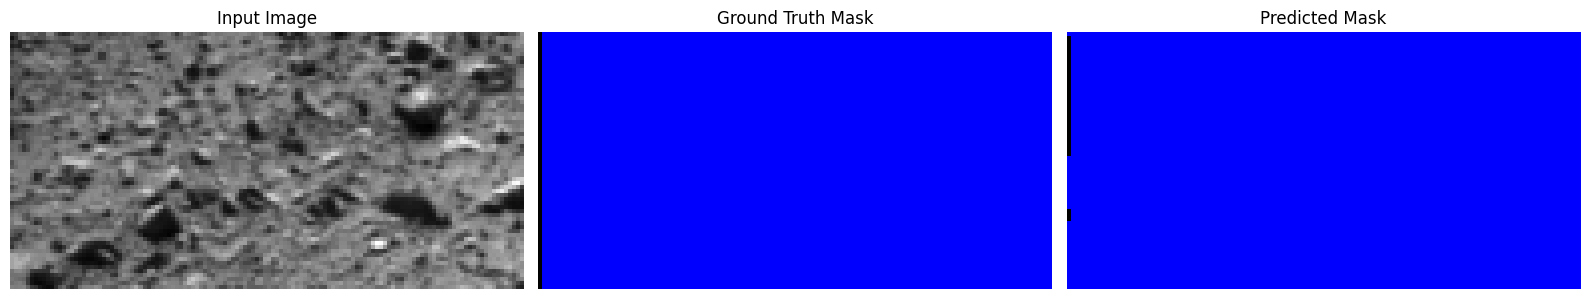

126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.9128 - loss: 0.2296 - mean_iou: 0.6111 - val_accuracy: 0.7434 - val_loss: 0.8286 - val_mean_iou: 0.4381
Epoch 97/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.9123 - loss: 0.2300 - mean_iou: 0.6359 - val_accuracy: 0.7283 - val_loss: 0.8038 - val_mean_iou: 0.4154
Epoch 98/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.9117 - loss: 0.2308 - mean_iou: 0.6403 - val_accuracy: 0.7731 - val_loss: 0.7902 - val_mean_iou: 0.4643
Epoch 99/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.9130 - loss: 0.2274 - mean_iou: 0.6324 - val_accuracy: 0.7414 - val_loss: 0.9188 - val_mean_iou: 0.4305
Epoch 100/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.9127 - loss: 0.2263 - mean_iou: 0.6257 - val_accuracy: 0.7394 - val_loss: 0.8417 - val_mean_iou: 0.4393
Epoch 101/250
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9149 - loss: 0.2205 - mean_iou: 0.6287

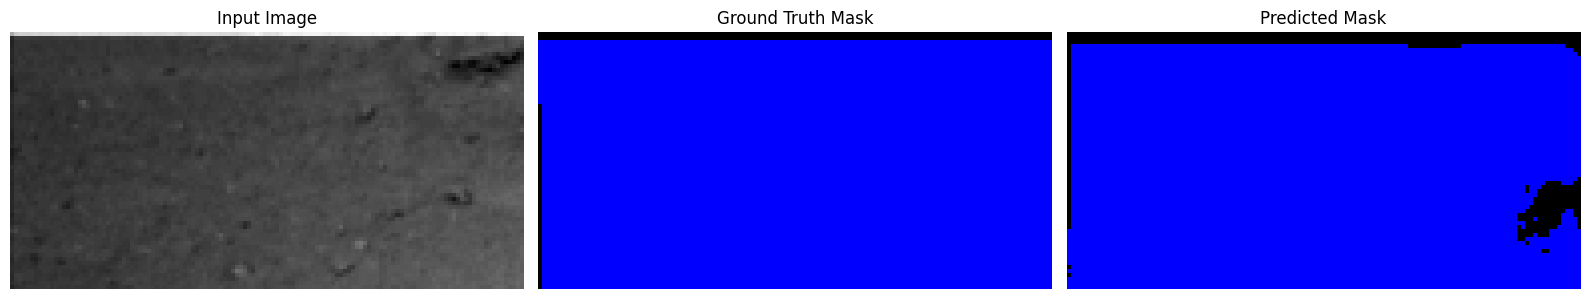

126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.9149 - loss: 0.2207 - mean_iou: 0.6285 - val_accuracy: 0.7608 - val_loss: 0.7261 - val_mean_iou: 0.4555
Epoch 102/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.9122 - loss: 0.2305 - mean_iou: 0.6146 - val_accuracy: 0.7273 - val_loss: 0.9430 - val_mean_iou: 0.4104
Epoch 103/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.9128 - loss: 0.2280 - mean_iou: 0.6243 - val_accuracy: 0.7745 - val_loss: 0.7197 - val_mean_iou: 0.4723


In [ ]:
history = model.fit(
    train_dataset,
    epochs=epoch,
    validation_data=val_dataset,
    callbacks=[early_stopping, viz_callback],
    verbose=1
).history

In [ ]:
# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation Accuracy: {final_val_accuracy}%')

final_val_loss = round(max(history['val_loss']), 2)
print(f'Final validation Loss: {final_val_loss}%')


# Definisci il percorso di salvataggio nella directory di lavoro
model.save("/kaggle/working/model_.keras")

# Delete the model to free up resources
del model

Final validation Mean Intersection Over Union: 50.95%
Final validation Accuracy: 79.92%
Final validation Loss: 10.76%


# Save Model

In [ ]:
#model_filename = "model_.keras"
#X_test = training_data["test_set"]
#model = tfk.models.load_model("/kaggle/working/model_.keras")

#preds = model.predict(X_test/255)
#preds = np.argmax(preds, axis=-1)
#print(f"Predictions shape: {preds.shape}")

In [ ]:
# THRESHOLD VERSION !!!

#threshold = 0.99

# Load the test dataset
#X_test = np.load("/kaggle/input/no-out/test_set.npz")["images"]

# Normalize test images
#X_test = X_test / 255.0  # Ensure pixel values are in [0, 1]

# Load the saved model with the custom loss function
#model_filename = "model_.keras"
#model = tfk.models.load_model("/kaggle/working/model_.keras")

# Predict on test data
#pred_probs = model.predict(X_test)  # Get raw probabilities

# Adjust predictions
#first_preds = np.argmax(pred_probs, axis=-1)  # Get the most probable class
#first_probs = np.max(pred_probs, axis=-1)
#second_most_probs = np.argsort(pred_probs, axis=-1)[:, :, :, -2]  # Get the second most probable class

# Update class 0 pixels to the second most probable class
# preds = np.where(first_preds == 0, second_most_probs, first_preds)

#preds = np.where(
#    (first_preds == 0) & (first_probs < threshold),  # Check for class 0 and probability < thresshold
#    second_most_probs,                              # Use second most probable class
#    first_preds                                # Otherwise, keep the original prediction
#)

# Print the shape of adjusted predictions
#print(f"Adjusted Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step
Adjusted Predictions shape: (10022, 64, 128)


In [ ]:
# ORIGINAL VERSION!!!

# Load the test dataset
X_test = np.load("/kaggle/input/no-out/test_set.npz")["images"]

# Normalize test images
X_test = X_test / 255.0  # Ensure pixel values are in [0, 1]

# Load the saved model with the custom loss function
model_filename = "model_not_th.keras"
model = tfk.models.load_model("/kaggle/working/model_.keras")

# Predict on test data
pred_probs = model.predict(X_test)  # Get raw probabilities

# Adjust predictions
first_preds = np.argmax(pred_probs, axis=-1)  # Get the most probable class
second_most_probs = np.argsort(pred_probs, axis=-1)[:, :, :, -2]  # Get the second most probable class

# Update class 0 pixels to the second most probable class
preds = np.where(first_preds == 0, second_most_probs, first_preds)

# Print the shape of adjusted predictions
print(f"Adjusted Predictions shape: {preds.shape}")


314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step
Adjusted Predictions shape: (10022, 64, 128)


In [ ]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)